In [1]:
# Recommendation: `conda install --channel conda-forge geopandas`
import numpy as np
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import shapely
import json
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from tqdm import tqdm
import os

import scorers
import redistricting
import matplotlib.ticker as ticker

In [2]:
def splits_to_regions_binary(row, splits):
    if splits is None:
        return 0
    if len(splits) == 0:
        return 0

    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

def count_disjoints(geometry):
    if type(geometry) == Polygon:
        return 1 
    else:
        return len(geometry.geoms)

In [3]:
data_path = "../data/mggg-states/"
output_dir = "../output/"
run_name = "2018_abs_both_comp"

state = "MD"
DEGREE_LIMIT = 0
# scorers 
# crs = "EPSG:6505"

states = pd.read_csv("../states_2010.csv")
row = states.loc[states['abbrev'] == state]
row = [r for i,r in row.iterrows()][0]

voting_precincts = gpd.read_file(os.path.join(data_path,row["abbrev"]))
# voting_precincts = voting_precincts.to_crs(crs)
n_districts = row["districts"]
pop = row["population"]
d_votes = "USH16D" #row["dem_votes"]
r_votes = "USH16R" #row["rep_votes"]
voting_precincts.sample(n=1)

,NAME,CNG02,COUNTY,LEG02,VTD,MCD,STATE,VTD_1,PLACE,UNADJPOP,...,NHPIVAP,OTHERVAP,2MOREVAP,CD,LEG10,ADJ_nBVAP,nBVAP,HDIST,SEND,geometry
780,Anne Arundel Precinct 05-031,2403,24003,24031,2400305-031,2400390376,24,05-031,2471200,772,...,0,0,5,04,031,460.0,460,31B,031,"POLYGON ((438939.552 159157.176, 438945.544 15..."


In [4]:
voting_precincts.columns

Index(['NAME', 'CNG02', 'COUNTY', 'LEG02', 'VTD', 'MCD', 'STATE', 'VTD_1',
       'PLACE', 'UNADJPOP',
       ...
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'CD', 'LEG10', 'ADJ_nBVAP', 'nBVAP',
       'HDIST', 'SEND', 'geometry'],
      dtype='object', length=104)

In [5]:
voting_precincts['REPRESENTATIVE_POINT'] =  voting_precincts.centroid # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263
voting_precincts['RP_LON'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
voting_precincts['RP_LAT'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

In [6]:
orig_voting = voting_precincts[[d_votes, r_votes]].sum()/(voting_precincts[[d_votes, r_votes]].sum().sum())
orig_voting

USH16D    0.629811
USH16R    0.370189
dtype: float64

In [7]:
holder = []   
redistricting.split_this(df=voting_precincts, n_districts=n_districts, pop_col=pop, dem_col=d_votes, rep_col=r_votes, orig_dem=orig_voting[d_votes], orig_rep=orig_voting[r_votes], degree_limit=DEGREE_LIMIT, score_fn=scorers.abs_diff_mean_fn, holder=holder)

100%|██████████| 360/360 [00:03<00:00, 99.01it/s] 


In [8]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)
all_districts['DISTRICT'].nunique()

8

In [9]:
# Shuffle for coloring
n_districts = all_districts['DISTRICT'].nunique()
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

In [10]:
print(all_districts.groupby("SHUFFLED").sum()[pop].sum())
pop_summary = all_districts.groupby("SHUFFLED").sum()[pop].reset_index()
pop_summary['pct_deviation'] = (pop_summary[pop] - (pop_summary[pop].sum()/n_districts))/(pop_summary[pop].sum()/n_districts)
pop_summary

5773552


C:\Users\yagne\AppData\Local\Temp\ipykernel_8444\1657365533.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(all_districts.groupby("SHUFFLED").sum()[pop].sum())
C:\Users\yagne\AppData\Local\Temp\ipykernel_8444\1657365533.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pop_summary = all_districts.groupby("SHUFFLED").sum()[pop].reset_index()


,SHUFFLED,TOTPOP,pct_deviation
0,0.0,723752,0.002852
1,1.0,723745,0.002842
2,2.0,715400,-0.008721
3,3.0,722710,0.001408
4,4.0,723011,0.001825
5,5.0,722439,0.001032
6,6.0,721197,-0.000689
7,7.0,721298,-0.000549


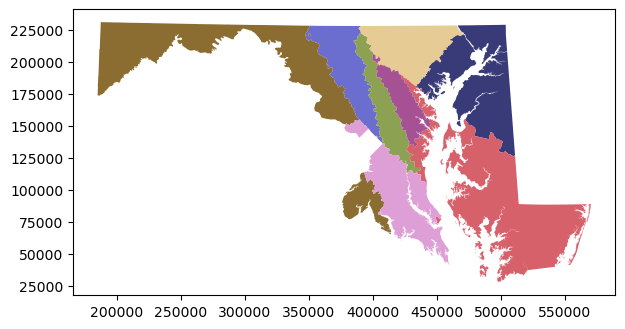

In [11]:
districts_df = all_districts.dissolve(by="SHUFFLED")
fig, ax = plt.subplots(1,1, figsize=(7,7))
districts_df.plot(ax=ax,cmap="tab20b")

# scale_x = 1e6
# scale_y = 1e6
# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
# ax.xaxis.set_major_formatter(ticks_x)

# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
# ax.yaxis.set_major_formatter(ticks_y)

fig.savefig(os.path.join(output_dir, row["abbrev"],f"{row['abbrev']}_{run_name}_base.png"))

In [12]:
all_districts[['geometry', pop, r_votes, d_votes, 'DISTRICT', 'SHUFFLED'] + split_columns].to_file(os.path.join(output_dir, row["abbrev"],f"{row['abbrev']}_{run_name}.shp"))

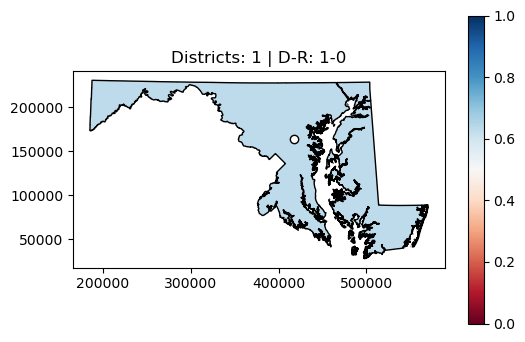

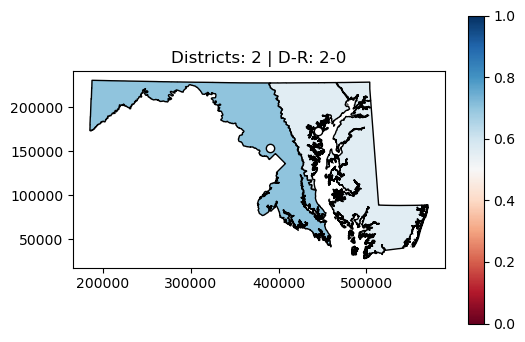

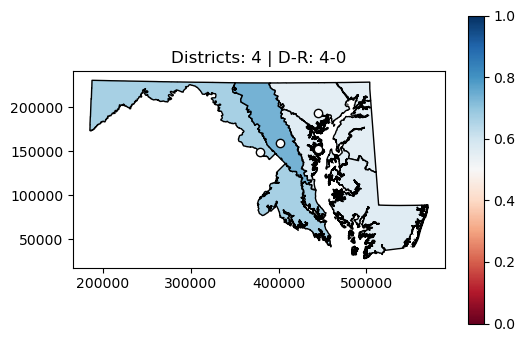

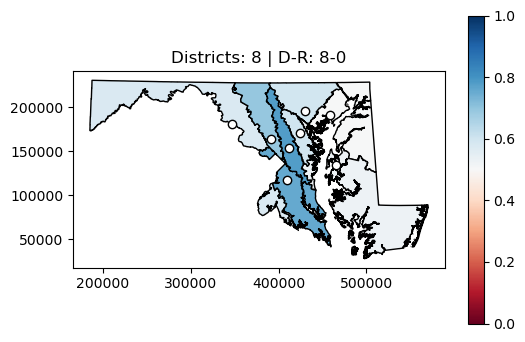

In [13]:
for i in range(len(split_columns)+1):
    redistricting.split_review(input_df=all_districts, split=i, split_cols=split_columns, d_votes=d_votes, r_votes=r_votes, pop=pop, plot_party=True, figsize=(6,4), save=os.path.join(output_dir, row["abbrev"],f"{row['abbrev']}_{run_name}_{i+1}.png"))
